# Data preprocessing and analysis

Endogenous Rhythmic Attention project, 2019-2023

<b>Author</b>: Olof J. van der Werf
<br><b>Last updated</b>: 04-08-2023

### Purpose of this notebook

This notebook preprocesses the data before data analysis.

<ul>
<li> Convolute trials with a Gaussian, creating time series </li>
<li> Detrending data </li>
<li> Permuting the data for analysis </li>
<li> Run stLSS analysis </li>
<li> Save output </li>
</ul>

### Import necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import time
import warnings
warnings.filterwarnings("ignore")

### Functions

In [2]:
# element-wise convolution with a gaussian in the time domain
def convolute(data):
    
    # element-wise subtraction to put in gaussian function
    arr = []
    for t in data['cue-target interval']:
        arr.append(t - intervals)
    
    # gaussian function
    W = np.exp(-(np.power(arr,2))/(2*sigma**2))

    # element-wise multiplication of gussian with values
    H = []
    for i,interval in enumerate(intervals):
        H.append(W[:,i] * data['reaction time'])
    H = np.transpose(H)
    
    # take sum of each to get time series
    W_sum = np.sum(W,0)
    H_sum = np.sum(H,0)
    ts = H_sum / W_sum
    
    # turn into series
    ts = pd.Series(ts, index = intervals)
    
    return ts

In [3]:
# element-wise detrending of the data 
def detrend(data,ts):
    coeff = np.polyfit(intervals,ts,1)
    trend = np.polyval(coeff,intervals)
    trend = pd.Series(trend,index = intervals)
    
    detrended = data.copy()
    detrended['reaction time'] = ''

    for i, row in data.iterrows():
        detrended.loc[i,'reaction time'] = data.loc[i,'reaction time'] - trend[detrended.loc[i,'cue-target interval']] 

    return detrended

In [4]:
# single trial least squares spectrum analysis
def stLSS(data):
    
    # hanning taper
    taper = pd.Series(np.hanning(len(intervals)),index = intervals)
    taper = taper / np.sum(taper)
    data = data.reset_index(drop=True)
    for i, row in data.iterrows():
        data.loc[i,'reaction time'] = data.loc[i,'reaction time'] * taper[data.loc[i,'cue-target interval']] 

    # stLSS
    power_spectrum = pd.Series(index=frequencies,dtype='float64')
    for frequency in frequencies:
        phase = data['cue-target interval'] * 2 * np.pi * frequency
        phase = phase.to_numpy()
        x = [np.ones(len(data['cue-target interval'])),np.cos(phase),np.sin(phase)]
        x = np.transpose(x)
        y = np.transpose([data['reaction time'].to_numpy().astype('float64')])
        x,resid,rank,s = np.linalg.lstsq(x,y,rcond=None)
        power_spectrum[frequency] = complex(x[1][0],x[2][0])
    
    power_spectrum = abs(power_spectrum)**2
        
    return power_spectrum

### Set variables

In [5]:
# folder where the clean data is
clean_data_folder = 'data/data_after_cleaning/'
results_folder = 'data/results/'

# time bins
start_time = 0.490
end_time = 1.690
resolution = 0.001
num_time_bins = int((end_time - start_time) / resolution) + 2
intervals = np.round(np.linspace(start_time, end_time, num = num_time_bins),3)

# frequency bins
low_freq = 2
high_freq = 20
resolution = 0.1
num_freq_bins = int((high_freq - low_freq) / resolution) + 1
frequencies =  np.linspace(low_freq, high_freq, num = num_freq_bins)

# sigma of the Gaussian for the convolution
sigma = 0.01

# permutations
nr_of_permutations = 1000
permutations = np.linspace(1,nr_of_permutations,nr_of_permutations).astype(int)

# relevant condition lists
conditions = ['60','80','100']
validities = ['valid','invalid']
visual_fields = ['left','right','both']
subjects = ['03','04','05','06','09','11','12','14','15','17','18','19','20','21','26','27','30','31','32','33','34','35','37','38','39','40']

## Import data

In [6]:
file = clean_data_folder +'trials.csv'
trials = pd.read_csv(file, sep = ',', index_col = 0,dtype = 'str', converters = {'cue-target interval': float, 'reaction time': float})
trials.head(10)

,subject,condition,validity,cue side,cue-target interval,reaction time,response
0,03,60,valid,right,1.500,674.346,correct
1,03,60,valid,right,1.033,535.099,correct
2,03,60,invalid,right,1.667,677.154,correct
3,03,60,invalid,right,0.700,642.355,correct
4,03,60,valid,left,1.200,649.998,correct
5,03,60,valid,right,0.983,453.680,correct
6,03,60,valid,right,1.517,466.662,correct
7,03,60,valid,left,0.917,478.815,correct
8,03,60,invalid,left,0.567,659.850,correct
9,03,60,valid,right,0.633,675.943,correct


## Run main pre-processing and analysis loop

Steps in this loop:
<ul>
<li> Filter data for the specific factor (validity, visual field, cue validity condition) </li>
<li> Convoluting trials to obtain a time series of reaction time accross cue-target intervals </li>
<li> Detrending trials </li>
<li> Run stLSS analysis </li>
<li> Save output </li>
</ul>

In [7]:
# Main loop
# loop through validities
for validity in validities:
    
    # loop through visual fields
    for visual_field in visual_fields:
            
        # loop through conditions
        for condition in conditions:
            
            if validity == 'invalid' and condition == '100':
                continue
            
            # filter the data
            if visual_field == 'both':
                # take a subset of the data with one condition (for pre-processing purposes)
                filtered = trials[(trials['validity'] == validity) &
                                (trials['condition'] == condition) &
                                (trials['response'] == 'correct')]
            else:
                # take a subset of the data with one condition (for pre-processing purposes)
                filtered = trials[(trials['validity'] == validity) &
                                (trials['cue side'] == visual_field) & 
                                (trials['condition'] == condition) &
                                (trials['response'] == 'correct')]  
            
            # reset index
            filtered = filtered.reset_index(drop = True)
            
            # convolute
            time_series = convolute(filtered)
                
            # save time series
            file = results_folder + 'time_series/' + validity + '_' + visual_field + '_' + condition + '.csv'
            #time_series.to_csv(file,index = True, header = True)
            
            # detrend
            detrended = detrend(filtered,time_series)
            
            # stLSS
            power_spectrum = stLSS(detrended)

            # save power spectrum
            file = results_folder + 'power_spectra/' + validity + '_' + visual_field + '_' + condition + '.csv'
            power_spectrum.to_csv(file,index = True, header = True)

### Permute cue-target intervals
Here, we shuffle cue-target interval labels, in order to compare our observed reaction times against them. We repeat all above analysis steps for each permutation.

Surrogate power spectrum for valid trials in left visual field(s), 60% cue validity:


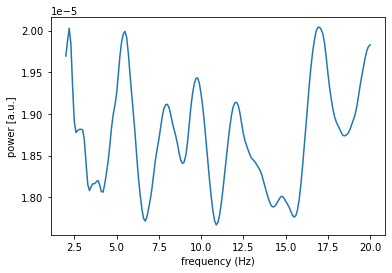

Execution time for this factor: 847 seconds  
Surrogate power spectrum for valid trials in left visual field(s), 80% cue validity:


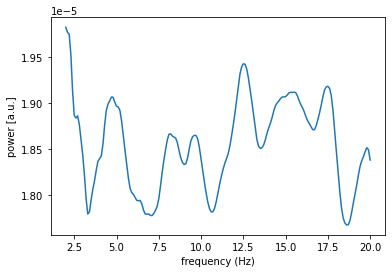

Execution time for this factor: 970 seconds  
Surrogate power spectrum for valid trials in left visual field(s), 100% cue validity:


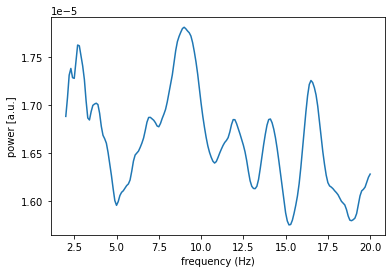

Execution time for this factor: 4083 seconds  
Surrogate power spectrum for valid trials in right visual field(s), 60% cue validity:


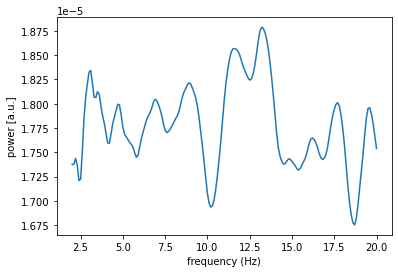

Execution time for this factor: 2171 seconds  
Surrogate power spectrum for valid trials in right visual field(s), 80% cue validity:


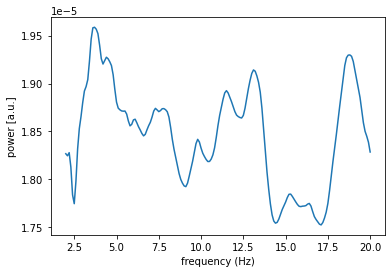

Execution time for this factor: 832 seconds  
Surrogate power spectrum for valid trials in right visual field(s), 100% cue validity:


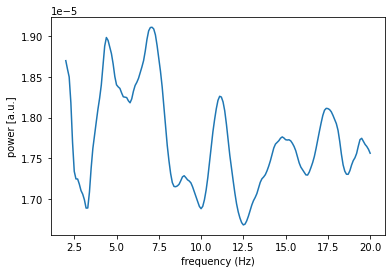

Execution time for this factor: 4098 seconds  
Surrogate power spectrum for valid trials in both visual field(s), 60% cue validity:


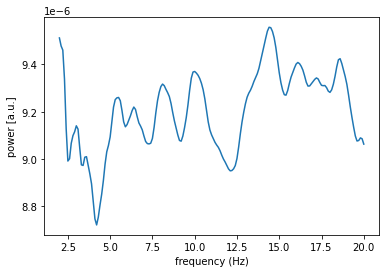

Execution time for this factor: 1944 seconds  
Surrogate power spectrum for valid trials in both visual field(s), 80% cue validity:


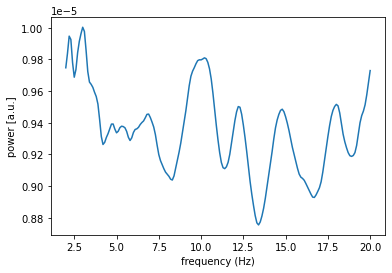

Execution time for this factor: 4058 seconds  
Surrogate power spectrum for valid trials in both visual field(s), 100% cue validity:


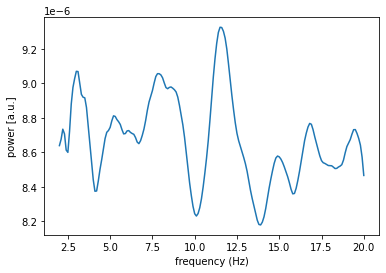

Execution time for this factor: 1432 seconds  
Surrogate power spectrum for invalid trials in left visual field(s), 60% cue validity:


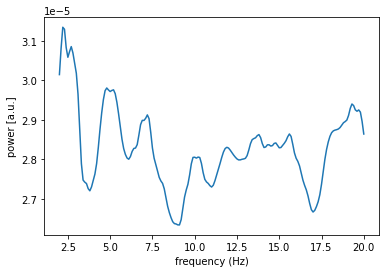

Execution time for this factor: 16830 seconds  
Surrogate power spectrum for invalid trials in left visual field(s), 80% cue validity:


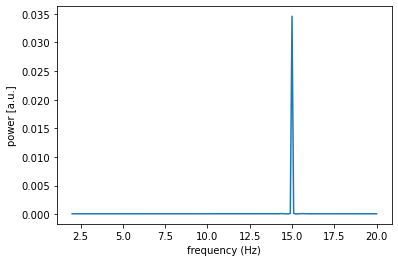

Execution time for this factor: 351 seconds  
Surrogate power spectrum for invalid trials in right visual field(s), 60% cue validity:


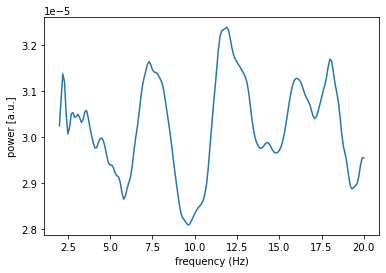

Execution time for this factor: 8873 seconds  
Surrogate power spectrum for invalid trials in right visual field(s), 80% cue validity:


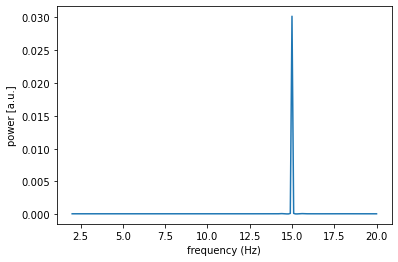

Execution time for this factor: 358 seconds  
Surrogate power spectrum for invalid trials in both visual field(s), 60% cue validity:


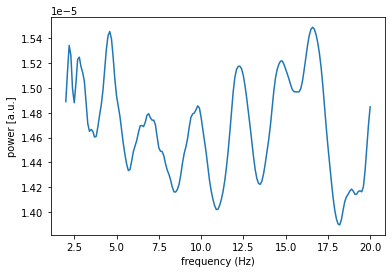

Execution time for this factor: 3820 seconds  
Surrogate power spectrum for invalid trials in both visual field(s), 80% cue validity:


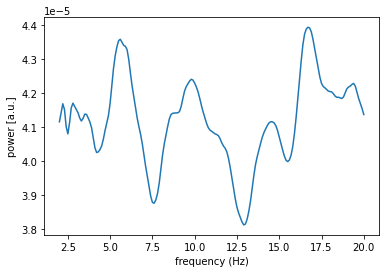

Execution time for this factor: 1495 seconds  


In [9]:
# Cue-target interval label permutations
# loop through validities
for validity in validities:
    
    # loop through visual fields
    for visual_field in visual_fields:
        
        # loop through conditions
        for condition in conditions:
            
            st = time.time()
            
            interval_permutations = pd.DataFrame()
            
            if validity == 'invalid' and condition == '100':
                continue
                
               # filter the data
            if visual_field == 'both':
                # take a subset of the data with one condition (for pre-processing purposes)
                filtered = trials[(trials['validity'] == validity) &
                                (trials['condition'] == condition) &
                                (trials['response'] == 'correct')]
            else:
                # take a subset of the data with one condition (for pre-processing purposes)
                filtered = trials[(trials['validity'] == validity) &
                                (trials['cue side'] == visual_field) & 
                                (trials['condition'] == condition) &
                                (trials['response'] == 'correct')]  
                        
            # set index of filtered (to later be able to align all permutations)
            filtered = filtered.reset_index(drop=True)
            #filtered['index'] = filtered.index 
            
            permutation = filtered.copy()
            
            for i in permutations:
                # get the start time
                
                # print 
                print('Validity: {}, visual field: {}, condition: {}, permutation: {}'.format(validity,visual_field, condition, i),end = '       \r')
                sys.stdout.flush()
                
                # shuffle data
                permutation['cue-target interval'] = np.random.permutation(permutation['cue-target interval'])
                
                # convolute
                time_series = convolute(permutation)

                # detrend
                detrended = detrend(permutation,time_series)

                # stLSS
                interval_permutations[i] = stLSS(detrended)
                
            # plot data
            print('Surrogate power spectrum for '+validity+' trials in '+visual_field+' visual field(s), '+condition+'% cue validity:')
            plt.plot(interval_permutations.mean(axis=1))
            plt.ylabel('power [a.u.]')
            plt.xlabel('frequency (Hz)')
            plt.show()
            
            # save data
            file = results_folder + 'permutations/interval_permutations/' + validity + '_' + visual_field + '_' + condition + '.csv'
            interval_permutations.to_csv(file,index = True, header = True)
            
            # get the end time
            et = time.time()

            # get the execution time
            elapsed_time = round(et - st)
            print('Execution time for this factor:', elapsed_time, 'seconds  \r')
            sys.stdout.flush()

### Permute condition labels
Here, we shuffle condition labels, in order to compare our observed reaction times against them (for the 'valid' trials). We repeat all above analysis steps for each permutation.

In [10]:
# Condition label permutations
# [only 'valid' trials are taken into consideration]

# loop through visual fields
for visual_field in visual_fields:
    
    st = time.time()
    
    condition_permutations = pd.DataFrame(columns = ['cue-target interval'])

    # filter the data
    if visual_field == 'both':
        # take a subset of the data with one factor
        filtered = trials[(trials['validity'] == 'valid') &
                          (trials['response'] == 'correct')]
    else:
        # take a subset of the data with one factor
        filtered = trials[(trials['validity'] == 'valid') &
                          (trials['cue side'] == visual_field) & 
                          (trials['response'] == 'correct')]
    
    filtered = filtered.reset_index(drop=True)
    filtered['index'] = filtered.index
    
    # initiate permutation dataframe
    condition_permutations = {}
    for condition in conditions:
        condition_permutations[condition] = pd.DataFrame()
    
    for i in permutations:
        
        permutation = pd.DataFrame()
        
        # loop through subjects
        for subject in subjects:

            # copy subset (just like above) and shuffle the condition labels
            subject_permutation = filtered[filtered['subject'] == subject].copy()
            subject_permutation['condition'] = np.random.permutation(subject_permutation['condition'])
            
            permutation = pd.concat((permutation,subject_permutation),ignore_index=True)

        # loop through conditions
        for condition in conditions:
                
            # Print
            print('visual field: {}, permutation: {}'.format(visual_field, i),end = '       \r')
            #sys.stdout.flush()

            # take subset for subject
            subset_one_condition = permutation[permutation['condition'] == condition]

            # run through cue-permutations
            ts = convolute(subset_one_condition)

            # detrend 
            subset_one_condition = detrend(subset_one_condition,ts)

            # add to subject permutations for all conditions
            condition_permutations[condition][i] = stLSS(subset_one_condition)
    
    # save data          
    for condition in conditions:
        
        file = results_folder + 'permutations/condition_permutations/valid_' + visual_field + '_' + condition + '.csv'
        #condition_permutations[condition].to_csv(file,index = True, header = True)

    # get the end time
    et = time.time()

    # get the execution time
    elapsed_time = round(et - st)
    print('Execution time for one visual field:', elapsed_time, 'seconds')


Execution time for one visual field: 10123 seconds
Execution time for one visual field: 7300 seconds
Execution time for one visual field: 14027 seconds


In [11]:
# save data          
for condition in conditions:

    file = results_folder + 'permutations/condition_permutations/' + validity + '_' + visual_field + '_' + condition + '.csv'
    condition_permutations[condition].to_csv(file,index = True, header = True)

## Run one-out analysis

As an extra analysis, to show that our group-averaged data is not being biased by just one participant, we re-run the steps above in an extra loop, whereby each time one participant is taken out.

In [12]:
# specify condition cell
validity = 'valid'
visual_field = 'right'
condition = '60'

sub_out_power_spectrum = pd.DataFrame()

# loop through one-out subjects
for sub_out in subjects:
     
    print('subject out: {}'.format(sub_out),end = '       \r')

    # take a subset of the data with one condition (for pre-processing purposes)
    filtered = trials[(trials['validity'] == validity) &
                    (trials['cue side'] == visual_field) & 
                    (trials['condition'] == condition) &
                    (trials['response'] == 'correct') &
                      (trials['subject'] != sub_out)]  

    # reset index
    filtered = filtered.reset_index(drop = True)

    # convolute
    time_series = convolute(filtered)

    # detrend
    detrended = detrend(filtered,time_series)

    # stLSS
    sub_out_power_spectrum[sub_out] = stLSS(detrended)

In [13]:
# Save power spectrum (subject-out)
file = results_folder + 'power_spectra/subject_out/valid_right_60.csv'
sub_out_power_spectrum.to_csv(file,index = True, header = True)

In [15]:
# Cue-target interval label permutations for one-out analysis
            
st = time.time()

sub_out_interval_permutations = {}

# loop through one-out subjects
for sub_out in subjects:
    sub_out_interval_permutations[sub_out] = pd.DataFrame()
    
    permutation = filtered.copy()

    for i in permutations:

        # print 
        print('subject: {}, permutation: {}'.format(sub_out,i),end = '       \r')
        #sys.stdout.flush()

        # shuffle data
        permutation['cue-target interval'] = np.random.permutation(permutation['cue-target interval'])

        # convolute
        time_series = convolute(permutation)

        # detrend
        detrended = detrend(permutation,time_series)

        # stLSS
        sub_out_interval_permutations[sub_out][i] = stLSS(detrended)

In [16]:
# Save interval permutations (subject-out)
for sub_out in subjects:
        
    file = results_folder + 'permutations/subject_out_permutations/valid_right_60_P'+sub_out+'.csv'
    sub_out_interval_permutations[sub_out].to_csv(file,index = True, header = True)

In [39]:
power_spectrum

{'03': 2.0     2.014875e-05
 2.1     1.678603e-05
 2.2     1.297383e-05
 2.3     9.075490e-06
 2.4     6.160746e-06
             ...     
 19.6    9.662312e-07
 19.7    1.680498e-06
 19.8    2.716869e-06
 19.9    3.969405e-06
 20.0    5.277439e-06
 Length: 181, dtype: float64,
 '04': 2.0     1.967248e-05
 2.1     1.476590e-05
 2.2     1.072659e-05
 2.3     7.982112e-06
 2.4     6.868339e-06
             ...     
 19.6    3.238181e-08
 19.7    1.931791e-07
 19.8    6.265075e-07
 19.9    1.266703e-06
 20.0    2.014269e-06
 Length: 181, dtype: float64,
 '05': 2.0     0.000010
 2.1     0.000008
 2.2     0.000006
 2.3     0.000004
 2.4     0.000003
           ...   
 19.6    0.000001
 19.7    0.000002
 19.8    0.000003
 19.9    0.000004
 20.0    0.000006
 Length: 181, dtype: float64,
 '06': 2.0     0.000022
 2.1     0.000017
 2.2     0.000013
 2.3     0.000009
 2.4     0.000006
           ...   
 19.6    0.000002
 19.7    0.000002
 19.8    0.000003
 19.9    0.000004
 20.0    0.000006
 Lengt

The end.